# Plot of the Week: Train vs Validation Loss Curves (Overfitting)

**Goal.** Fit a **nonlinear regression** model and plot **train vs validation loss vs epoch** to diagnose **overfitting**.

Students will **modify one element** (model size, regularization, optimizer hyperparameters, dataset size/noise, etc.) to **prevent overfitting**.

---

## What question does this plot answer?
How do the model’s training and validation losses evolve during training, and **does the gap indicate overfitting**?

## Why is it important?
Loss curves are a fast, reliable diagnostic for:
- **Overfitting vs underfitting**
- **Optimization stability** (learning rate too high/low, divergence, plateaus)
- **Experiment tracking** (comparing runs and hyperparameters)


In [16]:
# If you're running this on Colab, you might need:
# !pip install torch --quiet

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Reproducibility
torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## 1) Create a simple nonlinear regression dataset (simulated)

We’ll learn a noisy nonlinear function (a sinusoid with noise).
To make overfitting **easy to observe**, we use:
- relatively **small training set**
- a **high-capacity** model later


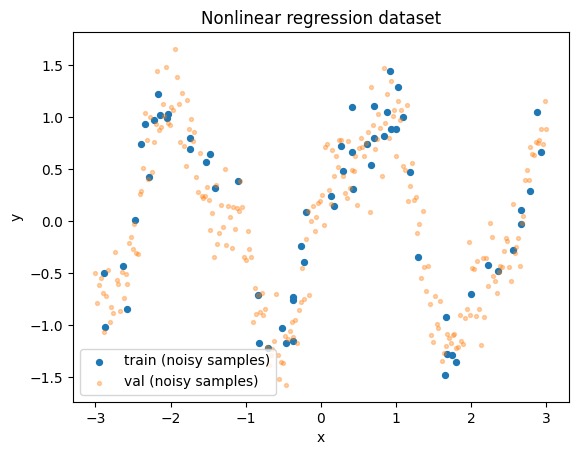

In [17]:
def make_sine_data(n_train=64, n_val=256, noise_std=0.25, x_range=(-3.0, 3.0)):
    # Train points
    x_train = np.random.uniform(x_range[0], x_range[1], size=(n_train, 1)).astype(np.float32)
    y_train = (np.sin(2.5 * x_train) + 0.3*np.cos(6 * x_train) + noise_std*np.random.randn(n_train, 1)).astype(np.float32)

    # Validation points (denser grid)
    x_val = np.linspace(x_range[0], x_range[1], n_val).reshape(-1, 1).astype(np.float32)
    y_val = (np.sin(2.5 * x_val) + 0.3*np.cos(6 * x_val) + noise_std*np.random.randn(n_val, 1)).astype(np.float32)
    return x_train, y_train, x_val, y_val

x_train, y_train, x_val, y_val = make_sine_data()

plt.figure()
plt.scatter(x_train, y_train, s=18, label="train (noisy samples)")
plt.scatter(x_val, y_val, s=8, alpha=0.35, label="val (noisy samples)")
plt.title("Nonlinear regression dataset")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## 2) Define a nonlinear regression model (MLP)

This MLP can easily **overfit** if:
- too many hidden units/layers
- training too long
- weak/no regularization

**Student knobs** (change these later): `hidden_dim`, `depth`, `dropout`, `weight_decay`.


In [18]:
class MLPRegressor(nn.Module):
    def __init__(self, in_dim=1, hidden_dim=256, depth=4, dropout=0.0):
        super().__init__()
        layers = []
        d = in_dim
        for _ in range(depth):
            layers.append(nn.Linear(d, hidden_dim))
            layers.append(nn.Tanh())  # smooth nonlinearity works well for this toy regression
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            d = hidden_dim
        layers.append(nn.Linear(d, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# Baseline model (intentionally high-capacity to provoke overfitting)
model = MLPRegressor(hidden_dim=256, depth=4, dropout=0.0).to(device)
sum(p.numel() for p in model.parameters())

198145

## 3) Training loop with logging

We log:
- training loss per epoch
- validation loss per epoch

and then plot them.

**Student knobs**: `lr`, `weight_decay`, `batch_size`, `epochs`.


In [19]:
def train_one_run(
    model,
    x_train, y_train, x_val, y_val,
    lr=3e-3,
    weight_decay=0.0,
    batch_size=32,
    epochs=300,
    print_every=50,
):
    # Data
    train_ds = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
    val_ds   = TensorDataset(torch.from_numpy(x_val), torch.from_numpy(y_val))
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=256, shuffle=False)

    # Loss + optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses = []
    val_losses = []

    for epoch in range(1, epochs + 1):
        # ---- train ----
        model.train()
        total = 0.0
        n = 0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            total += loss.item() * xb.size(0)
            n += xb.size(0)
        train_loss = total / n

        # ---- val ----
        model.eval()
        total = 0.0
        n = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                pred = model(xb)
                loss = criterion(pred, yb)
                total += loss.item() * xb.size(0)
                n += xb.size(0)
        val_loss = total / n

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if print_every and (epoch % print_every == 0 or epoch == 1 or epoch == epochs):
            print(f"epoch {epoch:4d} | train MSE {train_loss:.4f} | val MSE {val_loss:.4f}")

    return np.array(train_losses), np.array(val_losses)

# Run a baseline that often overfits
model = MLPRegressor(hidden_dim=256, depth=4, dropout=0.0).to(device)

train_losses, val_losses = train_one_run(
    model,
    x_train, y_train, x_val, y_val,
    lr=3e-3,
    weight_decay=0.0,
    batch_size=32,
    epochs=300,
    print_every=60,
)

epoch    1 | train MSE 1.7484 | val MSE 0.9339
epoch   60 | train MSE 0.2001 | val MSE 0.2398
epoch  120 | train MSE 0.0605 | val MSE 0.0987
epoch  180 | train MSE 0.0482 | val MSE 0.1132
epoch  240 | train MSE 0.0448 | val MSE 0.0876
epoch  300 | train MSE 0.0362 | val MSE 0.0849


## 4) Plot 1: Train vs Validation Loss Curves (minimum requirement)

**Interpretation tip:**  
Overfitting often looks like:
- train loss keeps decreasing
- validation loss bottoms out then starts increasing (or stops improving)



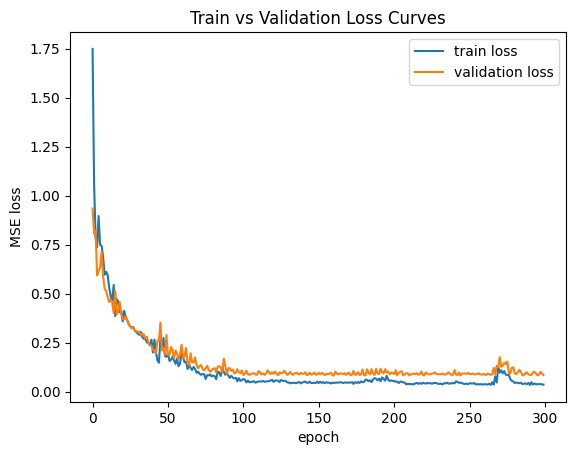

Best validation loss at epoch: 161 val_loss: 0.08291959762573242


In [20]:
plt.figure()
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title("Train vs Validation Loss Curves")
plt.legend()
plt.show()

# Optional: print epoch of best validation performance
best_epoch = int(val_losses.argmin()) + 1
print("Best validation loss at epoch:", best_epoch, "val_loss:", float(val_losses.min()))

## 5) Visualize the fitted function (helps explain overfitting)

This is optional but often makes the story clearer.


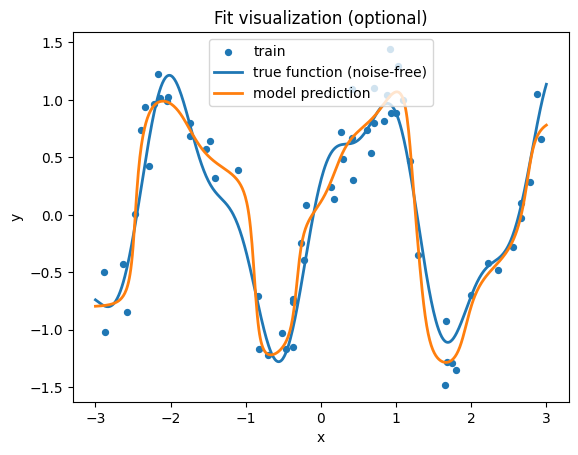

In [21]:
# Predict on a dense grid
model.eval()
x_grid = np.linspace(-3, 3, 600).reshape(-1, 1).astype(np.float32)
with torch.no_grad():
    y_pred = model(torch.from_numpy(x_grid).to(device)).cpu().numpy()

plt.figure()
plt.scatter(x_train, y_train, s=18, label="train")
plt.plot(x_grid, np.sin(2.5*x_grid) + 0.3*np.cos(6*x_grid), linewidth=2, label="true function (noise-free)")
plt.plot(x_grid, y_pred, linewidth=2, label="model prediction")
plt.title("Fit visualization (optional)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## 6) Student task: prevent overfitting

**Choose ONE change** and re-run the training cell(s). Then submit your updated **loss curve plot**.

### Suggested edits (pick one)
1. **Regularization**  
   - increase `weight_decay` (e.g., `1e-4`, `1e-3`, `1e-2`)  
   - add `dropout` (e.g., `0.1`–`0.3`)  
2. **Reduce model capacity**  
   - lower `hidden_dim` (e.g., `32`, `64`)  
   - reduce `depth` (e.g., `2`)  
3. **Train less / early stopping (simple version)**  
   - reduce `epochs`  
   - stop training near the best validation epoch  
4. **More data / less noise**  
   - increase `n_train` (e.g., `256`)  
   - reduce `noise_std` (e.g., `0.10`)  
5. **Optimizer dynamics**  
   - change `lr` (try `1e-3` or `1e-4`)  
   - change `batch_size`

### What “success” looks like
A run where **validation loss does not rise** (or rises much less), and the **train–val gap** is smaller.

---

## Required Submission Template

**Upload**:

the figure (PNG or PDF)

OR the notebook cell output

Short caption (1–2 sentences)

**Title:**  
Train vs Validation Loss Curves

**What question does this plot answer?**  
(1 sentence.)

**Description (1–2 sentences):**  
What data / model / comparison is shown?  
What change did you make, and what happened?




### Suggested edits (pick one)
1. **Regularization**  
   - increase `weight_decay` (e.g., `1e-4`, `1e-3`, `1e-2`)  
   - add `dropout` (e.g., `0.1`–`0.3`)  
2. **Reduce model capacity**  
   - lower `hidden_dim` (e.g., `32`, `64`)  
   - reduce `depth` (e.g., `2`)  
3. **Train less / early stopping (simple version)**  
   - reduce `epochs`  
   - stop training near the best validation epoch  
4. **More data / less noise**  
   - increase `n_train` (e.g., `256`)  
   - reduce `noise_std` (e.g., `0.10`)  
5. **Optimizer dynamics**  
   - change `lr` (try `1e-3` or `1e-4`)  
   - change `batch_size`

### What “success” looks like
A run where **validation loss does not rise** (or rises much less), and the **train–val gap** is smaller.

---

## Required Submission Template

**Upload**:

the figure (PNG or PDF)

OR the notebook cell output

Short caption (1–2 sentences)

**Title:**  
Train vs Validation Loss Curves

**What question does this plot answer?**  
(1 sentence.)

**Description (1–2 sentences):**  
What data / model / comparison is shown?  
What change did you make, and what happened?



### Starter cell for experiments (students edit this)

Edit the hyperparameters below, re-run, and regenerate **Plot 1**.


epoch    1 | train MSE 0.8852 | val MSE 0.5471
epoch   60 | train MSE 0.0285 | val MSE 0.0367
epoch  120 | train MSE 0.0188 | val MSE 0.0253
epoch  180 | train MSE 0.0140 | val MSE 0.0219
epoch  240 | train MSE 0.0244 | val MSE 0.0298
epoch  300 | train MSE 0.0154 | val MSE 0.0140


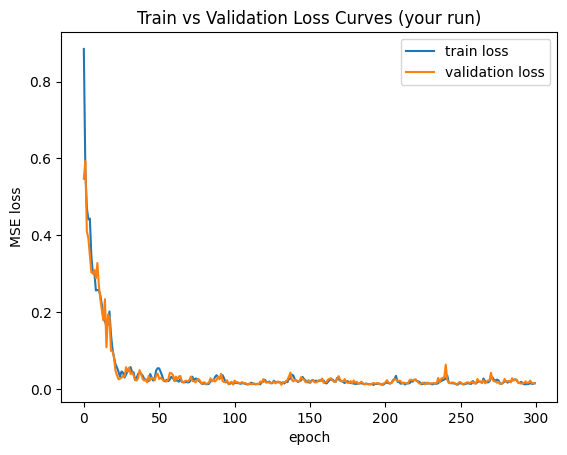

Best validation loss at epoch: 132 val_loss: 0.010790162719786167


In [22]:
# =========================
# STUDENTS: EDIT THESE
# =========================
n_train = 256
noise_std = 0.10

hidden_dim = 256
depth = 4
dropout = 0.

# Weight Decay: 1e-4, 1e-3, 1e-2
# Dropout: 0.1, 0.2, 0.3

lr = 3e-3
weight_decay = 0.
batch_size = 32
epochs = 300

# Recreate data + model, then train
x_train, y_train, x_val, y_val = make_sine_data(n_train=n_train, noise_std=noise_std)
model = MLPRegressor(hidden_dim=hidden_dim, depth=depth, dropout=dropout).to(device)

train_losses, val_losses = train_one_run(
    model,
    x_train, y_train, x_val, y_val,
    lr=lr,
    weight_decay=weight_decay,
    batch_size=batch_size,
    epochs=epochs,
    print_every=60,
)

# Plot 1 (required)
plt.figure()
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title("Train vs Validation Loss Curves (your run)")
plt.legend()
plt.show()

best_epoch = int(val_losses.argmin()) + 1
print("Best validation loss at epoch:", best_epoch, "val_loss:", float(val_losses.min()))

=== Baseline (default params) ===
epoch    1 | train MSE 1.7695 | val MSE 0.9691
epoch   60 | train MSE 0.1010 | val MSE 0.1006
epoch  120 | train MSE 0.0570 | val MSE 0.0839
epoch  180 | train MSE 0.0528 | val MSE 0.0726
epoch  240 | train MSE 0.0417 | val MSE 0.0677
epoch  300 | train MSE 0.0527 | val MSE 0.0688
BASELINE best_epoch=270 best_val=0.064454 gap=0.024909

=== All runs (sorted) ===


,tag,n_train,noise_std,best_epoch,best_val,gap_at_best,final_val
0,"data: n_train=128, noise_std=0.1",128,0.10,215,0.012736,-0.007054,0.014656
1,"data: n_train=256, noise_std=0.1",256,0.10,183,0.013165,0.002245,0.018676
2,"data: n_train=64, noise_std=0.1",64,0.10,297,0.013349,0.004142,0.014324
3,"data: n_train=64, noise_std=0.2",64,0.20,286,0.042990,0.003547,0.043195
4,"data: n_train=256, noise_std=0.2",256,0.20,100,0.044746,0.003703,0.067277
5,"data: n_train=128, noise_std=0.2",128,0.20,134,0.045929,-0.003970,0.052760
6,"data: n_train=64, noise_std=0.25",64,0.25,270,0.064454,0.024909,0.068792
7,"data: n_train=256, noise_std=0.25",256,0.25,100,0.070222,0.006507,0.082137
8,"data: n_train=128, noise_std=0.25",128,0.25,140,0.070701,0.005114,0.082012



=== BEST NON-DEFAULT CONFIG (to submit) ===
data: n_train=128, noise_std=0.1
best_epoch=215 best_val=0.012736 gap=-0.007054


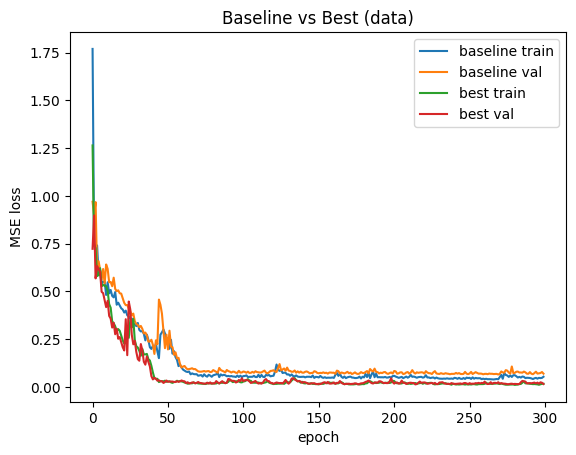

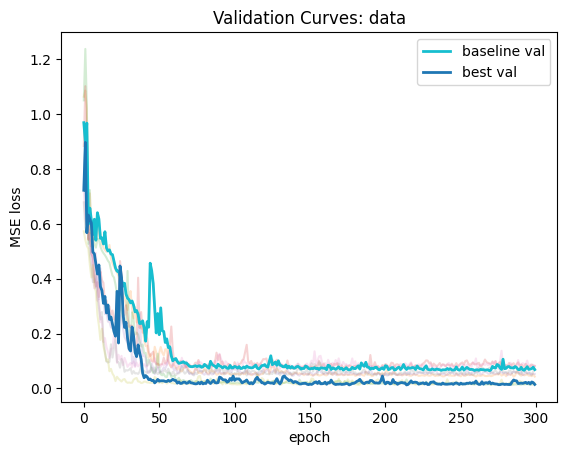

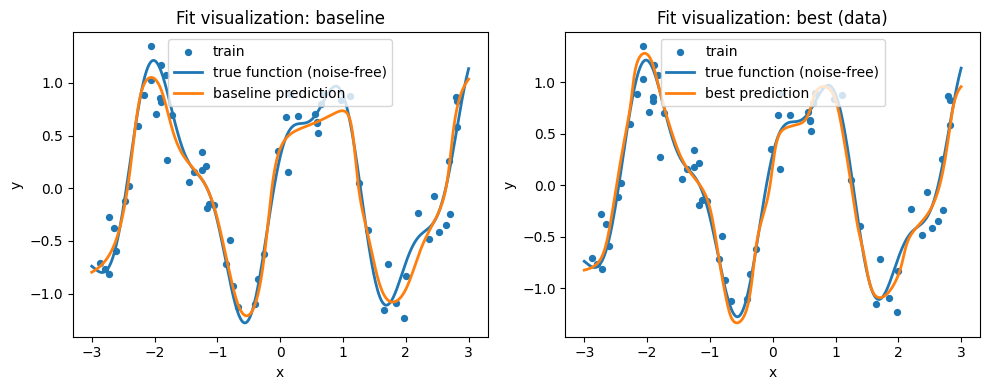

In [23]:
# ============================================================
# ONE-CELL SWEEP (pick one strategy) + LOSS CURVES + FIT PLOTS
# Requires already defined in notebook:
#   make_sine_data, MLPRegressor, train_one_run, device
# ============================================================

from __future__ import annotations

import itertools
from typing import Any, Dict, List, Tuple

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# =========================
# CHOOSE ONE STRATEGY HERE
# =========================
# STRATEGY = "regularization"
# STRATEGY = "capacity"
# STRATEGY = "early_stop"
STRATEGY = "data"
# STRATEGY = "optimizer"

# =========================
# DEFAULT PARAMS (match your notebook)
# =========================
SEED = 42
BASE_PARAMS = dict(
    n_train=64,
    noise_std=0.25,
    hidden_dim=256,
    depth=4,
    dropout=0.0,
    lr=3e-3,
    weight_decay=0.0,
    batch_size=32,
    epochs=300,
)

def _set_seeds(seed: int = SEED) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def _run_one(
    config: Dict[str, Any],
    x_train, y_train, x_val, y_val,
    print_every: int = 0,
    return_model: bool = False,
) -> Dict[str, Any]:
    """
    Train one model run and return metrics + curves (+ optional trained model).
    """
    _set_seeds(SEED)

    model = MLPRegressor(
        hidden_dim=int(config["hidden_dim"]),
        depth=int(config["depth"]),
        dropout=float(config["dropout"]),
    ).to(device)

    train_losses, val_losses = train_one_run(
        model,
        x_train, y_train, x_val, y_val,
        lr=float(config["lr"]),
        weight_decay=float(config["weight_decay"]),
        batch_size=int(config["batch_size"]),
        epochs=int(config["epochs"]),
        print_every=print_every,
    )

    train_losses = np.array(train_losses, dtype=float)
    val_losses = np.array(val_losses, dtype=float)

    best_idx = int(val_losses.argmin())
    best_epoch = best_idx + 1

    out = dict(config)
    out.update(
        best_epoch=best_epoch,
        best_val=float(val_losses[best_idx]),
        train_at_best=float(train_losses[best_idx]),
        gap_at_best=float(val_losses[best_idx] - train_losses[best_idx]),
        final_train=float(train_losses[-1]),
        final_val=float(val_losses[-1]),
        train_losses=train_losses,
        val_losses=val_losses,
    )
    if return_model:
        out["model"] = model
    return out

def _configs_for_strategy(strategy: str, base: Dict[str, Any]) -> Tuple[List[Dict[str, Any]], List[str]]:
    """
    Returns (configs, columns_to_display) for ONE strategy.
    """
    configs: List[Dict[str, Any]] = []

    if strategy == "regularization":
        dropout_grid = [0.0, 0.1, 0.2, 0.3]
        weight_decay_grid = [0.0, 1e-4, 1e-3, 1e-2]
        for d, wd in itertools.product(dropout_grid, weight_decay_grid):
            cfg = dict(base)
            cfg["dropout"] = d
            cfg["weight_decay"] = wd
            cfg["tag"] = f"regularization: dropout={d}, wd={wd:g}"
            configs.append(cfg)
        cols = ["dropout", "weight_decay", "best_epoch", "best_val", "gap_at_best", "final_val"]

    elif strategy == "capacity":
        hidden_dim_grid = [256, 128, 64, 32]
        depth_grid = [4, 3, 2]
        for h, dep in itertools.product(hidden_dim_grid, depth_grid):
            cfg = dict(base)
            cfg["hidden_dim"] = h
            cfg["depth"] = dep
            cfg["tag"] = f"capacity: hidden_dim={h}, depth={dep}"
            configs.append(cfg)
        cols = ["hidden_dim", "depth", "best_epoch", "best_val", "gap_at_best", "final_val"]

    elif strategy == "early_stop":
        epochs_grid = [300, 250, 200, 150, 100, 75]
        for e in epochs_grid:
            cfg = dict(base)
            cfg["epochs"] = e
            cfg["tag"] = f"early_stop: epochs={e}"
            configs.append(cfg)
        cols = ["epochs", "best_epoch", "best_val", "gap_at_best", "final_val"]

    elif strategy == "data":
        n_train_grid = [64, 128, 256]
        noise_grid = [0.25, 0.20, 0.10]
        for n, ns in itertools.product(n_train_grid, noise_grid):
            cfg = dict(base)
            cfg["n_train"] = n
            cfg["noise_std"] = ns
            cfg["tag"] = f"data: n_train={n}, noise_std={ns}"
            configs.append(cfg)
        cols = ["n_train", "noise_std", "best_epoch", "best_val", "gap_at_best", "final_val"]

    elif strategy == "optimizer":
        lr_grid = [3e-3, 1e-3, 3e-4, 1e-4]
        batch_grid = [32, 64, 128]
        for lr, bs in itertools.product(lr_grid, batch_grid):
            cfg = dict(base)
            cfg["lr"] = lr
            cfg["batch_size"] = bs
            cfg["tag"] = f"optimizer: lr={lr:g}, batch_size={bs}"
            configs.append(cfg)
        cols = ["lr", "batch_size", "best_epoch", "best_val", "gap_at_best", "final_val"]

    else:
        raise ValueError(f"Unknown STRATEGY={strategy}")

    return configs, cols

def _is_non_default(row: pd.Series, base: Dict[str, Any], strategy: str) -> bool:
    if strategy == "regularization":
        return not (float(row["dropout"]) == float(base["dropout"]) and float(row["weight_decay"]) == float(base["weight_decay"]))
    if strategy == "capacity":
        return not (int(row["hidden_dim"]) == int(base["hidden_dim"]) and int(row["depth"]) == int(base["depth"]))
    if strategy == "early_stop":
        return not (int(row["epochs"]) == int(base["epochs"]))
    if strategy == "data":
        return not (int(row["n_train"]) == int(base["n_train"]) and float(row["noise_std"]) == float(base["noise_std"]))
    if strategy == "optimizer":
        return not (float(row["lr"]) == float(base["lr"]) and int(row["batch_size"]) == int(base["batch_size"]))
    return True

def _plot_fit_side_by_side(baseline_run: Dict[str, Any], best_run: Dict[str, Any], x_train, y_train) -> None:
    # Dense grid
    x_grid = np.linspace(-3, 3, 600).reshape(-1, 1).astype(np.float32)
    # True function (noise-free) – matches your notebook
    y_true = np.sin(2.5 * x_grid) + 0.3 * np.cos(6 * x_grid)

    def _predict(run: Dict[str, Any]) -> np.ndarray:
        model = run["model"]
        model.eval()
        with torch.no_grad():
            return model(torch.from_numpy(x_grid).to(device)).cpu().numpy()

    y_pred_base = _predict(baseline_run)
    y_pred_best = _predict(best_run)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.scatter(x_train, y_train, s=18, label="train")
    plt.plot(x_grid, y_true, linewidth=2, label="true function (noise-free)")
    plt.plot(x_grid, y_pred_base, linewidth=2, label="baseline prediction")
    plt.title("Fit visualization: baseline")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(x_train, y_train, s=18, label="train")
    plt.plot(x_grid, y_true, linewidth=2, label="true function (noise-free)")
    plt.plot(x_grid, y_pred_best, linewidth=2, label="best prediction")
    plt.title(f"Fit visualization: best ({STRATEGY})")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()

    plt.tight_layout()
    plt.show()

# ============================================================
# RUN SWEEP
# ============================================================
_set_seeds(SEED)

changes_data = (STRATEGY == "data")

# Baseline dataset (always defined for plotting)
x_train0, y_train0, x_val0, y_val0 = make_sine_data(
    n_train=int(BASE_PARAMS["n_train"]),
    noise_std=float(BASE_PARAMS["noise_std"]),
)

print("=== Baseline (default params) ===")
baseline = _run_one(dict(BASE_PARAMS, tag="BASELINE"), x_train0, y_train0, x_val0, y_val0, print_every=60, return_model=True)
print(f"BASELINE best_epoch={baseline['best_epoch']} best_val={baseline['best_val']:.6f} gap={baseline['gap_at_best']:.6f}")

configs, display_cols = _configs_for_strategy(STRATEGY, BASE_PARAMS)

results = []
for cfg in configs:
    if changes_data:
        x_train, y_train, x_val, y_val = make_sine_data(
            n_train=int(cfg["n_train"]),
            noise_std=float(cfg["noise_std"]),
        )
    else:
        x_train, y_train, x_val, y_val = x_train0, y_train0, x_val0, y_val0

    res = _run_one(cfg, x_train, y_train, x_val, y_val, print_every=0, return_model=False)
    results.append(res)

df = pd.DataFrame([{
    **{k: r.get(k) for k in ["tag", "n_train", "noise_std", "hidden_dim", "depth", "dropout", "lr", "weight_decay", "batch_size", "epochs"]},
    "best_epoch": r["best_epoch"],
    "best_val": r["best_val"],
    "gap_at_best": r["gap_at_best"],
    "final_val": r["final_val"],
} for r in results])

df_sorted = df.sort_values(["best_val", "gap_at_best"], ascending=[True, True]).reset_index(drop=True)

print("\n=== All runs (sorted) ===")
cols_to_show = [c for c in ["tag"] + display_cols if c in df_sorted.columns]
display(df_sorted[cols_to_show])

df_nondefault = df_sorted[df_sorted.apply(lambda row: _is_non_default(row, BASE_PARAMS, STRATEGY), axis=1)].reset_index(drop=True)
best_row = df_nondefault.iloc[0] if len(df_nondefault) > 0 else df_sorted.iloc[0]

print("\n=== BEST NON-DEFAULT CONFIG (to submit) ===")
print(best_row["tag"])
print(f"best_epoch={int(best_row['best_epoch'])} best_val={float(best_row['best_val']):.6f} gap={float(best_row['gap_at_best']):.6f}")

# Re-run BEST once with return_model=True so we can do fit visualization
best_cfg = dict(BASE_PARAMS)
best_cfg.update({k: best_row[k] for k in ["n_train","noise_std","hidden_dim","depth","dropout","lr","weight_decay","batch_size","epochs"] if k in best_row and pd.notna(best_row[k])})
best_cfg["tag"] = best_row["tag"]

if changes_data:
    x_train_b, y_train_b, x_val_b, y_val_b = make_sine_data(
        n_train=int(best_cfg["n_train"]),
        noise_std=float(best_cfg["noise_std"]),
    )
else:
    x_train_b, y_train_b, x_val_b, y_val_b = x_train0, y_train0, x_val0, y_val0

best = _run_one(best_cfg, x_train_b, y_train_b, x_val_b, y_val_b, return_model=True)

# ============================================================
# PLOTS: loss curves + validation curves + fit comparison
# ============================================================

# 1) Loss curves (baseline vs best)
plt.figure()
plt.plot(baseline["train_losses"], label="baseline train")
plt.plot(baseline["val_losses"], label="baseline val")
plt.plot(best["train_losses"], label="best train")
plt.plot(best["val_losses"], label="best val")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title(f"Baseline vs Best ({STRATEGY})")
plt.legend()
plt.show()

# 2) Validation curves (all configs) + baseline/best highlighted
plt.figure()
for r in results:
    plt.plot(r["val_losses"], alpha=0.20)
plt.plot(baseline["val_losses"], label="baseline val", linewidth=2)
plt.plot(best["val_losses"], label="best val", linewidth=2)
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title(f"Validation Curves: {STRATEGY}")
plt.legend()
plt.show()

# 3) Fit visualization: baseline vs best (side-by-side)
# Use baseline dataset for the scatter so it matches the "default story"
_plot_fit_side_by_side(baseline, best, x_train0, y_train0)


=== Baseline (default params) ===
epoch    1 | train MSE 1.7695 | val MSE 0.9691
epoch   60 | train MSE 0.1010 | val MSE 0.1006
epoch  120 | train MSE 0.0570 | val MSE 0.0839
epoch  180 | train MSE 0.0528 | val MSE 0.0726
epoch  240 | train MSE 0.0417 | val MSE 0.0677
epoch  300 | train MSE 0.0527 | val MSE 0.0688
BASELINE best_epoch=270 best_val=0.064454 gap=0.024909

=== All runs (sorted) ===


,tag,n_train,noise_std,best_epoch,best_val,gap_at_best,final_val
0,"data: n_train=128, noise_std=0.1",128,0.10,215,0.012736,-0.007054,0.014656
1,"data: n_train=256, noise_std=0.1",256,0.10,183,0.013165,0.002245,0.018676
2,"data: n_train=64, noise_std=0.1",64,0.10,297,0.013349,0.004142,0.014324
3,"data: n_train=64, noise_std=0.2",64,0.20,286,0.042990,0.003547,0.043195
4,"data: n_train=256, noise_std=0.2",256,0.20,100,0.044746,0.003703,0.067277
5,"data: n_train=128, noise_std=0.2",128,0.20,134,0.045929,-0.003970,0.052760
6,"data: n_train=64, noise_std=0.25",64,0.25,270,0.064454,0.024909,0.068792
7,"data: n_train=256, noise_std=0.25",256,0.25,100,0.070222,0.006507,0.082137
8,"data: n_train=128, noise_std=0.25",128,0.25,140,0.070701,0.005114,0.082012



=== BEST NON-DEFAULT CONFIG (to submit) ===
data: n_train=128, noise_std=0.1
best_epoch=215 best_val=0.012736 gap=-0.007054


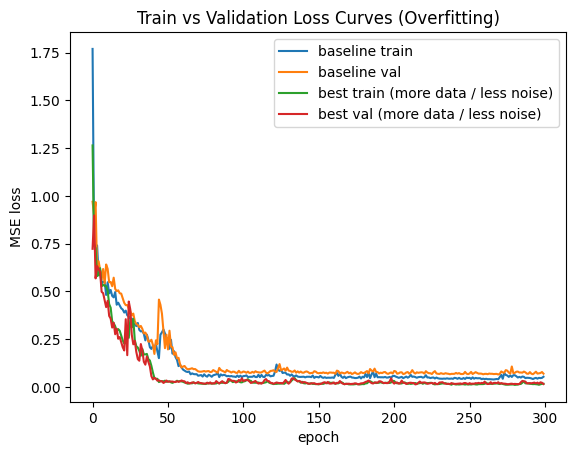


Baseline best val @ epoch 270 val_loss: 0.06445351988077164
Best (data/noise) best val @ epoch 215 val_loss: 0.012735605239868164
Baseline gap_at_best: 0.02490895800292492 | Best gap_at_best: -0.007054471410810947


In [24]:
# ============================================================
# 6) Student task: prevent overfitting
# Choose ONE change (we use: More data / less noise)
# Then submit the updated LOSS CURVE PLOT comparing baseline vs best.
#
# Requires already defined in your notebook:
#   make_sine_data, MLPRegressor, train_one_run, device
# ============================================================

from __future__ import annotations

from typing import Any, Dict, List, Tuple
import itertools

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt


# =========================
# PICK ONE STRATEGY
# =========================
STRATEGY = "data"  # <- "More data / less noise"


# =========================
# BASELINE (default params)
# =========================
SEED = 42
BASE_PARAMS = dict(
    n_train=64,
    noise_std=0.25,
    hidden_dim=256,
    depth=4,
    dropout=0.0,
    lr=3e-3,
    weight_decay=0.0,
    batch_size=32,
    epochs=300,
)


def _set_seeds(seed: int = SEED) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def _run_one(
    config: Dict[str, Any],
    x_train, y_train, x_val, y_val,
    print_every: int = 0,
) -> Dict[str, Any]:
    """Train one run and return metrics + loss curves."""
    _set_seeds(SEED)

    model = MLPRegressor(
        hidden_dim=int(config["hidden_dim"]),
        depth=int(config["depth"]),
        dropout=float(config["dropout"]),
    ).to(device)

    train_losses, val_losses = train_one_run(
        model,
        x_train, y_train, x_val, y_val,
        lr=float(config["lr"]),
        weight_decay=float(config["weight_decay"]),
        batch_size=int(config["batch_size"]),
        epochs=int(config["epochs"]),
        print_every=print_every,
    )

    train_losses = np.array(train_losses, dtype=float)
    val_losses = np.array(val_losses, dtype=float)

    best_idx = int(val_losses.argmin())
    best_epoch = best_idx + 1

    out = dict(config)
    out.update(
        best_epoch=best_epoch,
        best_val=float(val_losses[best_idx]),
        train_at_best=float(train_losses[best_idx]),
        gap_at_best=float(val_losses[best_idx] - train_losses[best_idx]),
        final_train=float(train_losses[-1]),
        final_val=float(val_losses[-1]),
        train_losses=train_losses,
        val_losses=val_losses,
    )
    return out


def _configs_more_data_less_noise(base: Dict[str, Any]) -> Tuple[List[Dict[str, Any]], List[str]]:
    """
    Option 4: More data / less noise
      - increase n_train (e.g., 256)
      - reduce noise_std (e.g., 0.10)
    We sweep a small grid and pick the best NON-BASELINE config.
    """
    configs: List[Dict[str, Any]] = []
    n_train_grid = [base["n_train"], 128, 256]
    noise_grid = [base["noise_std"], 0.20, 0.10]

    for n, ns in itertools.product(n_train_grid, noise_grid):
        cfg = dict(base)
        cfg["n_train"] = int(n)
        cfg["noise_std"] = float(ns)
        cfg["tag"] = f"data: n_train={n}, noise_std={ns}"
        configs.append(cfg)

    cols = ["n_train", "noise_std", "best_epoch", "best_val", "gap_at_best", "final_val"]
    return configs, cols


def _is_non_default_data(row: pd.Series, base: Dict[str, Any]) -> bool:
    return not (
        int(row["n_train"]) == int(base["n_train"])
        and float(row["noise_std"]) == float(base["noise_std"])
    )


# ============================================================
# RUN: baseline + sweep (data/noise) + pick best + REQUIRED PLOT
# ============================================================
_set_seeds(SEED)

# --- Baseline run (default params) ---
x_train0, y_train0, x_val0, y_val0 = make_sine_data(
    n_train=int(BASE_PARAMS["n_train"]),
    noise_std=float(BASE_PARAMS["noise_std"]),
)

print("=== Baseline (default params) ===")
baseline = _run_one(dict(BASE_PARAMS, tag="BASELINE"), x_train0, y_train0, x_val0, y_val0, print_every=60)
print(f"BASELINE best_epoch={baseline['best_epoch']} best_val={baseline['best_val']:.6f} gap={baseline['gap_at_best']:.6f}")

# --- Sweep Option 4: More data / less noise ---
configs, cols = _configs_more_data_less_noise(BASE_PARAMS)

results = []
for cfg in configs:
    # regenerate dataset per config (because n_train/noise_std changes)
    x_train, y_train, x_val, y_val = make_sine_data(
        n_train=int(cfg["n_train"]),
        noise_std=float(cfg["noise_std"]),
    )
    res = _run_one(cfg, x_train, y_train, x_val, y_val, print_every=0)
    results.append(res)

# --- Results table (optional, helpful for you) ---
df = pd.DataFrame([{
    "tag": r["tag"],
    "n_train": r["n_train"],
    "noise_std": r["noise_std"],
    "best_epoch": r["best_epoch"],
    "best_val": r["best_val"],
    "gap_at_best": r["gap_at_best"],
    "final_val": r["final_val"],
} for r in results])

df_sorted = df.sort_values(["best_val", "gap_at_best"], ascending=[True, True]).reset_index(drop=True)
print("\n=== All runs (sorted) ===")
display(df_sorted[["tag"] + cols])

# --- Pick best NON-BASELINE config ---
df_nondefault = df_sorted[df_sorted.apply(lambda row: _is_non_default_data(row, BASE_PARAMS), axis=1)].reset_index(drop=True)
best_row = df_nondefault.iloc[0] if len(df_nondefault) > 0 else df_sorted.iloc[0]

print("\n=== BEST NON-DEFAULT CONFIG (to submit) ===")
print(best_row["tag"])
print(f"best_epoch={int(best_row['best_epoch'])} best_val={float(best_row['best_val']):.6f} gap={float(best_row['gap_at_best']):.6f}")

# Re-run the best config ONCE so we can generate the required loss curve plot cleanly
best_cfg = dict(BASE_PARAMS)
best_cfg["n_train"] = int(best_row["n_train"])
best_cfg["noise_std"] = float(best_row["noise_std"])
best_cfg["tag"] = str(best_row["tag"])

x_train_b, y_train_b, x_val_b, y_val_b = make_sine_data(
    n_train=int(best_cfg["n_train"]),
    noise_std=float(best_cfg["noise_std"]),
)

best = _run_one(best_cfg, x_train_b, y_train_b, x_val_b, y_val_b, print_every=0)

# ============================================================
# REQUIRED SUBMISSION PLOT: LOSS CURVE (baseline vs best)
# (Title EXACTLY matches your notebook requirement)
# ============================================================
plt.figure()
plt.plot(baseline["train_losses"], label="baseline train")
plt.plot(baseline["val_losses"], label="baseline val")
plt.plot(best["train_losses"], label="best train (more data / less noise)")
plt.plot(best["val_losses"], label="best val (more data / less noise)")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title("Train vs Validation Loss Curves (Overfitting)")
plt.legend()
plt.show()

# Optional: print the best epoch for your write-up
print("\nBaseline best val @ epoch", baseline["best_epoch"], "val_loss:", baseline["best_val"])
print("Best (data/noise) best val @ epoch", best["best_epoch"], "val_loss:", best["best_val"])
print("Baseline gap_at_best:", baseline["gap_at_best"], "| Best gap_at_best:", best["gap_at_best"])
